In [56]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

In [57]:
os.getcwd()

'd:\\study\\graduation project\\GP-2025-Strain\\Code\\Data_scripts'

In [58]:
# Define the base directory path
Ali_base_dir = "D:\study\graduation project\ACDC\database" #Relative path to the database folder
Osama_base_dir = ""
Muhannad_base_dir = ""
Ahmed_base_dir = "" 
base_dir = Ali_base_dir
training_dir = os.path.join(base_dir, "training")
testing_dir = os.path.join(base_dir, "testing")

In [59]:
# Function to parse .cfg file and extract ED/ES frame numbers and other features
def parse_cfg_file(cfg_file_path):
    features = {}
    
    # Read the .cfg file line by line and extract the relevant information
    with open(cfg_file_path, 'r') as file:
        for line in file:
            key, value = line.split(':')
            key = key.strip()
            value = value.strip()
            features[key] = value
    
    return features

# Function to extract metadata from a NIfTI file (.nii)
def extract_nii_metadata(nii_file_path):
    # Check if the path is a directory
    if os.path.isdir(nii_file_path):
        # If it's a directory, find the .nii file inside the directory
        nii_files = [f for f in os.listdir(nii_file_path) if f.endswith('.nii')]
        if nii_files:
            # Update nii_file_path to point to the actual .nii file inside the directory
            nii_file_path = os.path.join(nii_file_path, nii_files[0])
        else:
            raise FileNotFoundError(f"No .nii file found in directory: {nii_file_path}")
    
    # Now load the .nii file
    nii_data = nib.load(nii_file_path)
    
    # Extract metadata
    header = nii_data.header
    voxel_size = header.get_zooms()  # Voxel dimensions
    resolution = header.get_data_shape()  # Image resolution
    field_of_view = tuple(res * vox for res, vox in zip(resolution, voxel_size))  # Field of view
    
    # Create a dictionary with the metadata
    metadata = {
        'Resolution': resolution,
        'Voxel_Size': voxel_size,
        'Field_of_View': field_of_view
    }
    
    return metadata

# Function to extract the ED and ES frame file names based on the info.cfg file
def get_ed_es_files(patient_dir, cfg_data):
    ed_frame = cfg_data.get('ED')
    es_frame = cfg_data.get('ES')
    
    ed_file = None
    es_file = None
    
    # Look for the correct ED and ES files based on the frame numbers from cfg_data
    for folder in os.listdir(patient_dir):
        # Ensure it's a folder with .nii extension, then check inside for the actual .nii file
        folder_path = os.path.join(patient_dir, folder)
        if os.path.isdir(folder_path) and folder.endswith('.nii'):
            files_in_folder = os.listdir(folder_path)
            # Check for files with .nii extension inside the folder
            for file in files_in_folder:
                if file.endswith('.nii'):
                    if f'frame{ed_frame}' in folder:
                        ed_file = os.path.join(folder_path, file)
                    if f'frame{es_frame}' in folder:
                        es_file = os.path.join(folder_path, file)
    
    return ed_file, es_file

# Function to check for files in patient folders and extract metadata
def check_patient_files(base_path):
    patient_data = []
    
    # List the subdirectories (patients) in the base path
    for folder in os.listdir(base_path):
        patient_dir = os.path.join(base_path, folder)
        
        # Ensure it is a directory (patient folder)
        if os.path.isdir(patient_dir):
            # Get the list of files in the patient directory
            patient_files = os.listdir(patient_dir)
            
            # Check for 4D and cfg files
            has_4d_file = next((f for f in patient_files if f.endswith('_4d.nii')), None)
            cfg_file = next((f for f in patient_files if f.endswith('.cfg')), None)
            
            row = {
                'Patient': folder,
                'Has_4D_File': 'Yes' if has_4d_file else 'No'
            }
            
            # If the cfg file exists, parse it to get the ED/ES frames
            if cfg_file:
                cfg_file_path = os.path.join(patient_dir, cfg_file)
                cfg_data = parse_cfg_file(cfg_file_path)
                row.update({
                    'ED': cfg_data.get('ED'),
                    'ES': cfg_data.get('ES'),
                    'Group': cfg_data.get('Group'),
                    'Height': float(cfg_data.get('Height', 0)),
                    'NbFrame': int(cfg_data.get('NbFrame', 0)),
                    'Weight': float(cfg_data.get('Weight', 0)),
                })
                
                # Extract ED and ES file paths based on frame numbers
                ed_file, es_file = get_ed_es_files(patient_dir, cfg_data)
                
                # Extract metadata for ED and ES frames if they exist
                if ed_file:
                    row.update({f'ED_{k}': v for k, v in extract_nii_metadata(ed_file).items()})
                if es_file:
                    row.update({f'ES_{k}': v for k, v in extract_nii_metadata(es_file).items()})
            
            # If the 4D file exists, extract metadata
            if has_4d_file:
                nii_file_path = os.path.join(patient_dir, has_4d_file)
                row.update(extract_nii_metadata(nii_file_path))
            
            # Add the row to patient_data list
            patient_data.append(row)
    
    # Create a DataFrame from the collected patient data
    df = pd.DataFrame(patient_data)
    return df

# Call the function and create the DataFrame for training and testing datasets
df_training_patients = check_patient_files(training_dir)
df_testing_patients = check_patient_files(testing_dir)

print(df_training_patients)
print(df_testing_patients)

       Patient Has_4D_File ED  ES Group  Height  NbFrame  Weight  \
0   patient001          No  1  12   DCM   184.0       30    95.0   
1   patient002          No  1  12   DCM   160.0       30    70.0   
2   patient003          No  1  15   DCM   165.0       30    77.0   
3   patient004          No  1  15   DCM   159.0       28    46.0   
4   patient005          No  1  13   DCM   165.0       30    77.0   
..         ...         ... ..  ..   ...     ...      ...     ...   
95  patient096         Yes  1   8    RV   186.0       15    76.0   
96  patient097         Yes  1  11    RV   187.0       30    82.0   
97  patient098         Yes  1   9    RV   167.0       22    50.0   
98  patient099         Yes  1   9    RV   180.0       19    80.0   
99  patient100         Yes  1  13    RV   165.0       34    63.0   

     ED_Resolution                 ED_Voxel_Size  \
0   (216, 256, 10)        (1.5625, 1.5625, 10.0)   
1   (232, 256, 10)  (1.3671875, 1.3671875, 10.0)   
2   (256, 256, 10)        (

In [60]:
# Display the first few rows of the DataFrames for training and testing
print("Training Data Preview:")
print(df_training_patients.head())


Training Data Preview:
      Patient Has_4D_File ED  ES Group  Height  NbFrame  Weight  \
0  patient001          No  1  12   DCM   184.0       30    95.0   
1  patient002          No  1  12   DCM   160.0       30    70.0   
2  patient003          No  1  15   DCM   165.0       30    77.0   
3  patient004          No  1  15   DCM   159.0       28    46.0   
4  patient005          No  1  13   DCM   165.0       30    77.0   

    ED_Resolution                 ED_Voxel_Size          ED_Field_of_View  \
0  (216, 256, 10)        (1.5625, 1.5625, 10.0)     (337.5, 400.0, 100.0)   
1  (232, 256, 10)  (1.3671875, 1.3671875, 10.0)  (317.1875, 350.0, 100.0)   
2  (256, 256, 10)        (1.5625, 1.5625, 10.0)     (400.0, 400.0, 100.0)   
3  (232, 256, 10)  (1.3671875, 1.3671875, 10.0)  (317.1875, 350.0, 100.0)   
4  (256, 216, 10)      (1.40625, 1.40625, 10.0)    (360.0, 303.75, 100.0)   

    ES_Resolution                 ES_Voxel_Size          ES_Field_of_View  \
0  (216, 256, 10)        (1.5625, 

In [61]:

print("\nTesting Data Preview:")
print(df_testing_patients.head())


Testing Data Preview:
      Patient Has_4D_File ED  ES Group  Height  NbFrame  Weight  \
0  patient101         Yes  1  14   DCM   169.0       30    79.0   
1  patient102         Yes  1  13   NOR   156.0       30    75.0   
2  patient103         Yes  1  11  MINF   175.0       30   107.0   
3  patient104         Yes  1  11   HCM   180.0       30    74.0   
4  patient105         Yes  1  10   HCM   173.0       30    84.0   

           Resolution                     Voxel_Size  \
0  (232, 256, 10, 30)  (1.64062, 1.64062, 10.0, 1.0)   
1   (216, 256, 8, 30)    (1.5625, 1.5625, 10.0, 1.0)   
2   (216, 256, 9, 30)    (1.5625, 1.5625, 10.0, 1.0)   
3   (208, 256, 9, 30)  (1.36719, 1.36719, 10.0, 1.0)   
4  (232, 256, 10, 30)  (1.48438, 1.48438, 10.0, 1.0)   

                                       Field_of_View  
0  (380.6238384246826, 419.99871826171875, 100.0,...  
1                         (337.5, 400.0, 80.0, 30.0)  
2                         (337.5, 400.0, 90.0, 30.0)  
3  (284.375520706

In [62]:
# Split 'ED_Resolution' and 'ES_Resolution' into separate columns
df_training_patients[['ED_Resolution_X', 'ED_Resolution_Y', 'ED_Resolution_Z']] = pd.DataFrame(df_training_patients['ED_Resolution'].tolist(), index=df_training_patients.index)
df_training_patients[['ES_Resolution_X', 'ES_Resolution_Y', 'ES_Resolution_Z']] = pd.DataFrame(df_training_patients['ES_Resolution'].tolist(), index=df_training_patients.index)

# Split 'ED_Voxel_Size' and 'ES_Voxel_Size' into separate columns
df_training_patients[['ED_Voxel_Size_X', 'ED_Voxel_Size_Y', 'ED_Voxel_Size_Z']] = pd.DataFrame(df_training_patients['ED_Voxel_Size'].tolist(), index=df_training_patients.index)
df_training_patients[['ES_Voxel_Size_X', 'ES_Voxel_Size_Y', 'ES_Voxel_Size_Z']] = pd.DataFrame(df_training_patients['ES_Voxel_Size'].tolist(), index=df_training_patients.index)

# Split 'ED_Field_of_View' and 'ES_Field_of_View' into separate columns
df_training_patients[['ED_FOV_X', 'ED_FOV_Y', 'ED_FOV_Z']] = pd.DataFrame(df_training_patients['ED_Field_of_View'].tolist(), index=df_training_patients.index)
df_training_patients[['ES_FOV_X', 'ES_FOV_Y', 'ES_FOV_Z']] = pd.DataFrame(df_training_patients['ES_Field_of_View'].tolist(), index=df_training_patients.index)

# Group by 'Patient' and calculate meaningful descriptive statistics
patient_stats_training_meta = df_training_patients.describe()

print("Training Data Meta-Data Stats:")
print(patient_stats_training_meta)

Training Data Meta-Data Stats:
           Height     NbFrame      Weight  ED_Resolution_X  ED_Resolution_Y  \
count  100.000000  100.000000  100.000000        66.000000        66.000000   
mean   170.840000   26.980000   74.960000       224.000000       247.787879   
std      9.710683    6.078576   16.632037        24.130415        29.469418   
min    140.000000   12.000000   35.000000       154.000000       154.000000   
25%    165.000000   25.000000   62.750000       208.000000       256.000000   
50%    171.500000   30.000000   75.000000       216.000000       256.000000   
75%    178.000000   30.000000   85.000000       246.000000       256.000000   
max    192.000000   35.000000  123.000000       276.000000       384.000000   

       ED_Resolution_Z  ES_Resolution_X  ES_Resolution_Y  ES_Resolution_Z  \
count        66.000000        67.000000        67.000000        67.000000   
mean          9.181818       222.955224       247.432836         9.149254   
std           1.753319    

In [63]:
# Split 'Resolution', 'Voxel_Size', and 'Field_of_View' into separate columns
df_testing_patients[['Resolution_X', 'Resolution_Y', 'Resolution_Z', 'Resolution_T']] = pd.DataFrame(df_testing_patients['Resolution'].tolist(), index=df_testing_patients.index)
df_testing_patients[['Voxel_Size_X', 'Voxel_Size_Y', 'Voxel_Size_Z', 'Voxel_Size_T']] = pd.DataFrame(df_testing_patients['Voxel_Size'].tolist(), index=df_testing_patients.index)
df_testing_patients[['FOV_X', 'FOV_Y', 'FOV_Z', 'FOV_T']] = pd.DataFrame(df_testing_patients['Field_of_View'].tolist(), index=df_testing_patients.index)

# Group by 'Patient' and calculate meaningful descriptive statistics
patient_stats_testing_meta = df_testing_patients.describe()

print("\nTesting Data Meta-Data Stats Patient:")
print(patient_stats_testing_meta)



Testing Data Meta-Data Stats Patient:
           Height    NbFrame      Weight  Resolution_X  Resolution_Y  \
count   50.000000  50.000000   50.000000      50.00000     50.000000   
mean   170.000000  25.480000   80.700000     218.92000    235.160000   
std      9.508321   6.713495   21.978886      26.36389     29.477324   
min    137.000000  14.000000   35.000000     154.00000    162.000000   
25%    165.000000  19.000000   68.500000     214.00000    216.000000   
50%    170.000000  30.000000   80.000000     216.00000    256.000000   
75%    175.000000  30.000000   90.750000     232.00000    256.000000   
max    185.000000  35.000000  172.000000     256.00000    288.000000   

       Resolution_Z  Resolution_T  Voxel_Size_X  Voxel_Size_Y  Voxel_Size_Z  \
count     50.000000     50.000000     50.000000     50.000000      50.00000   
mean      10.760000     25.480000      1.524564      1.524564       9.10000   
std        3.437845      6.713495      0.144272      0.144272       1.94044

### Visualizing the Distributions of Height, Weight, and Number of Frames

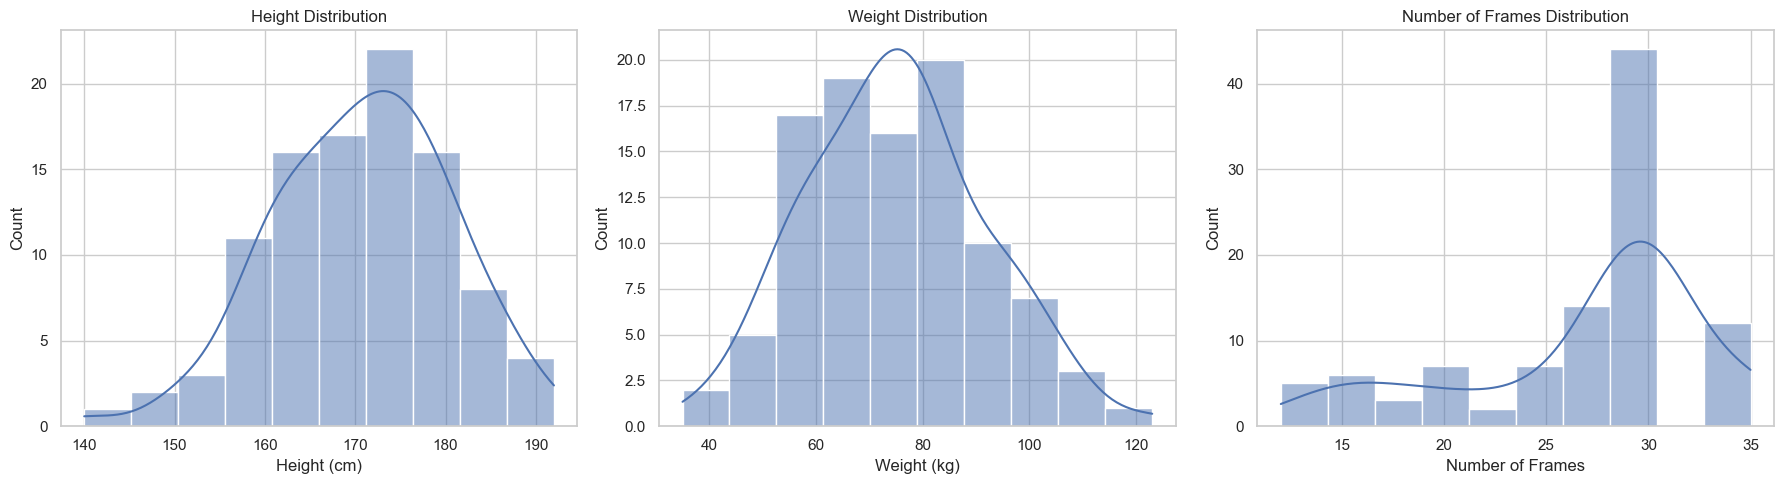

In [64]:
# Set up the aesthetics for the plots
sns.set(style="whitegrid")

# 1. Visualize distributions of height, weight, and number of frames
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_training_patients['Height'], bins=10, kde=True, ax=ax[0])
ax[0].set_title('Height Distribution')
ax[0].set_xlabel('Height (cm)')

sns.histplot(df_training_patients['Weight'], bins=10, kde=True, ax=ax[1])
ax[1].set_title('Weight Distribution')
ax[1].set_xlabel('Weight (kg)')

sns.histplot(df_training_patients['NbFrame'], bins=10, kde=True, ax=ax[2])
ax[2].set_title('Number of Frames Distribution')
ax[2].set_xlabel('Number of Frames')

plt.tight_layout()
plt.show()

### Visualizing the Resolution of the Images

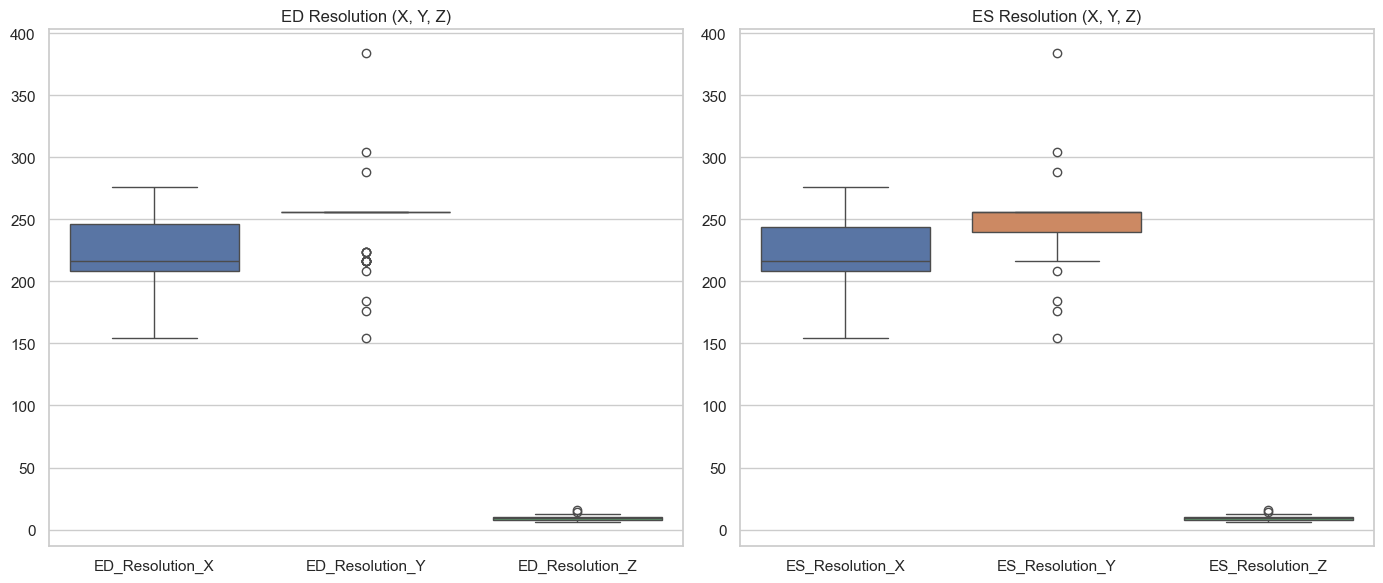

In [65]:
# 2. Visualizing ED and ES Resolution using Boxplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# ED Resolution boxplot
sns.boxplot(data=df_training_patients[['ED_Resolution_X', 'ED_Resolution_Y', 'ED_Resolution_Z']], ax=ax[0])
ax[0].set_title('ED Resolution (X, Y, Z)')

# ES Resolution boxplot
sns.boxplot(data=df_training_patients[['ES_Resolution_X', 'ES_Resolution_Y', 'ES_Resolution_Z']], ax=ax[1])
ax[1].set_title('ES Resolution (X, Y, Z)')

plt.tight_layout()
plt.show()


### Side-by-Side Comparison of ED vs ES for Resolution and Voxel Size

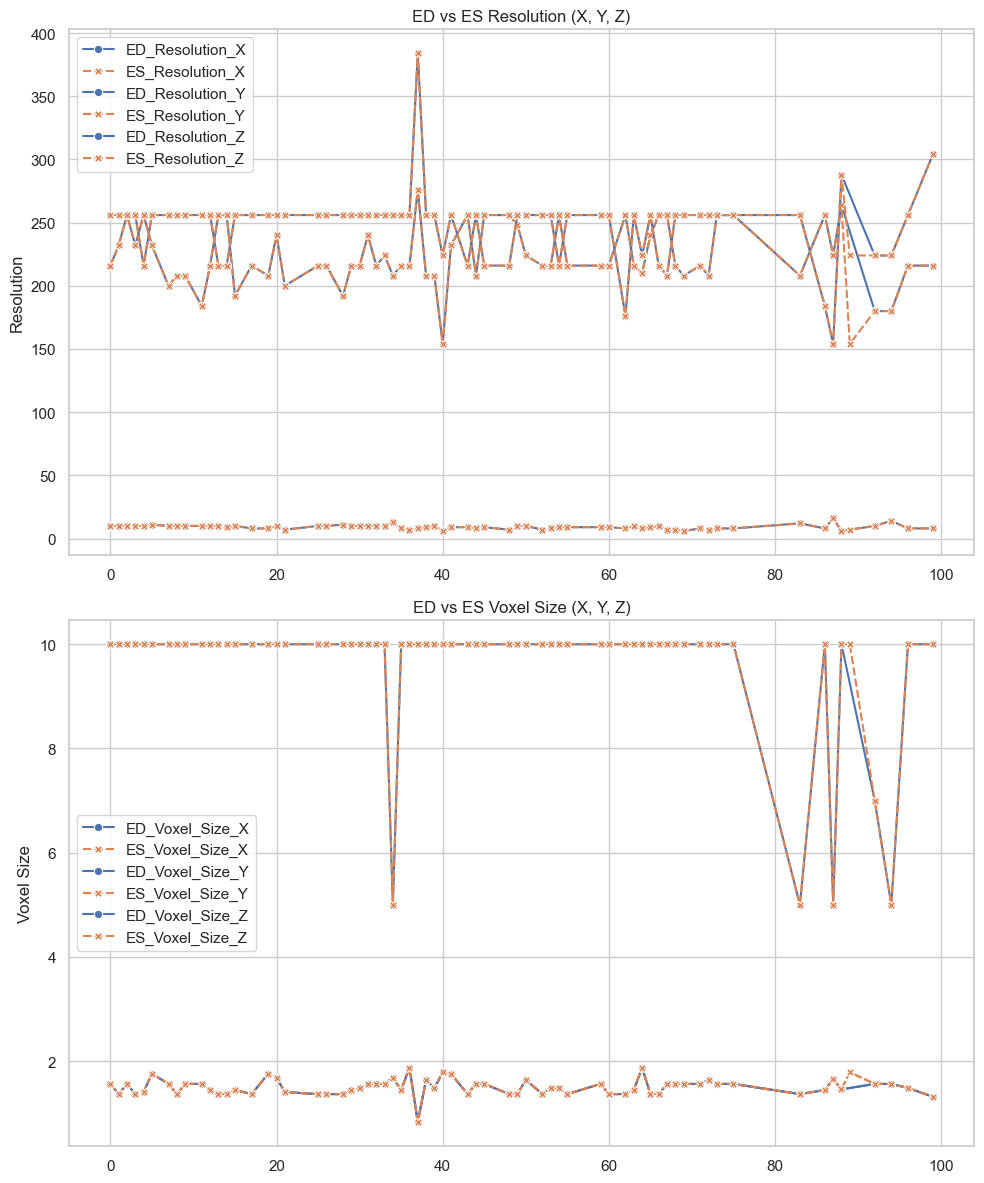

In [67]:
# 4. Side-by-Side Comparison of ED vs ES for Resolution and Voxel Size
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# ED vs ES Resolution Comparison
sns.lineplot(data=df_training_patients[['ED_Resolution_X', 'ES_Resolution_X']], ax=ax[0], markers=True)
sns.lineplot(data=df_training_patients[['ED_Resolution_Y', 'ES_Resolution_Y']], ax=ax[0], markers=True)
sns.lineplot(data=df_training_patients[['ED_Resolution_Z', 'ES_Resolution_Z']], ax=ax[0], markers=True)
ax[0].set_title('ED vs ES Resolution (X, Y, Z)')
ax[0].set_ylabel('Resolution')

# ED vs ES Voxel Size Comparison
sns.lineplot(data=df_training_patients[['ED_Voxel_Size_X', 'ES_Voxel_Size_X']], ax=ax[1], markers=True)
sns.lineplot(data=df_training_patients[['ED_Voxel_Size_Y', 'ES_Voxel_Size_Y']], ax=ax[1], markers=True)
sns.lineplot(data=df_training_patients[['ED_Voxel_Size_Z', 'ES_Voxel_Size_Z']], ax=ax[1], markers=True)
ax[1].set_title('ED vs ES Voxel Size (X, Y, Z)')
ax[1].set_ylabel('Voxel Size')

plt.tight_layout()
plt.show()

## Visualizing testing data

### Histograms for Numeric Columns

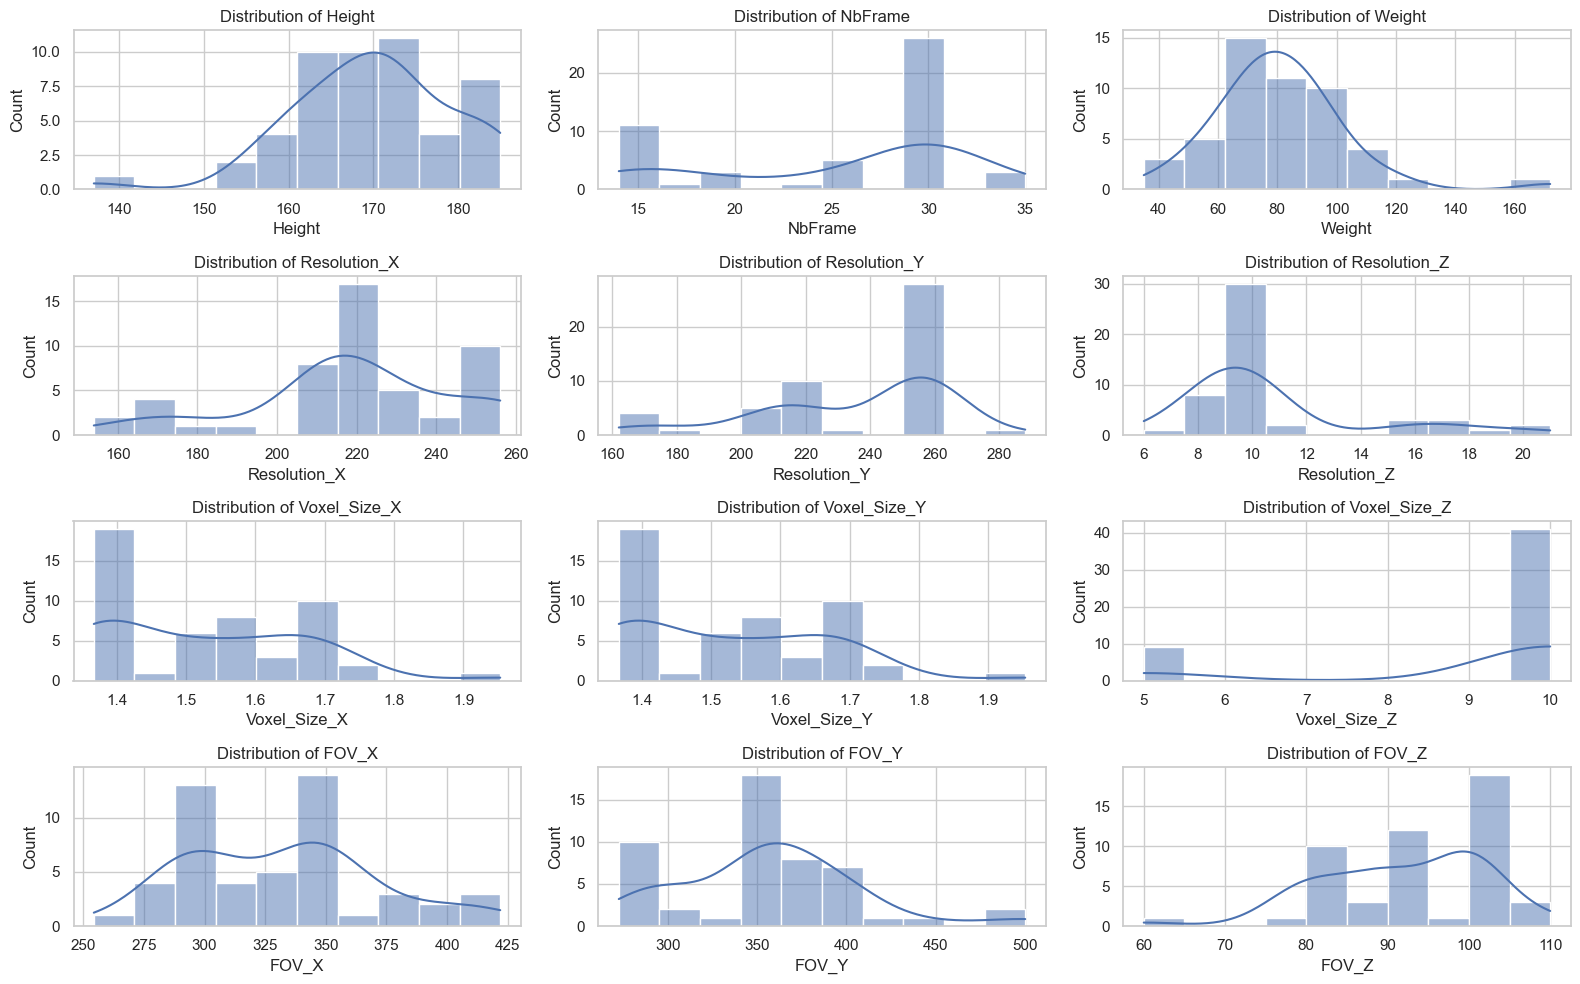

In [68]:
# Set up the figure
plt.figure(figsize=(16, 10))

# Create histograms for Height, Weight, NbFrame, and other numeric features
numeric_columns = ['Height', 'NbFrame', 'Weight', 'Resolution_X', 'Resolution_Y', 
                   'Resolution_Z', 'Voxel_Size_X', 'Voxel_Size_Y', 'Voxel_Size_Z', 'FOV_X', 'FOV_Y', 'FOV_Z']

# Loop through the numeric columns and create histograms
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df_testing_patients[col], bins=10, kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

###  Boxplots to Visualize Distribution and Outliers

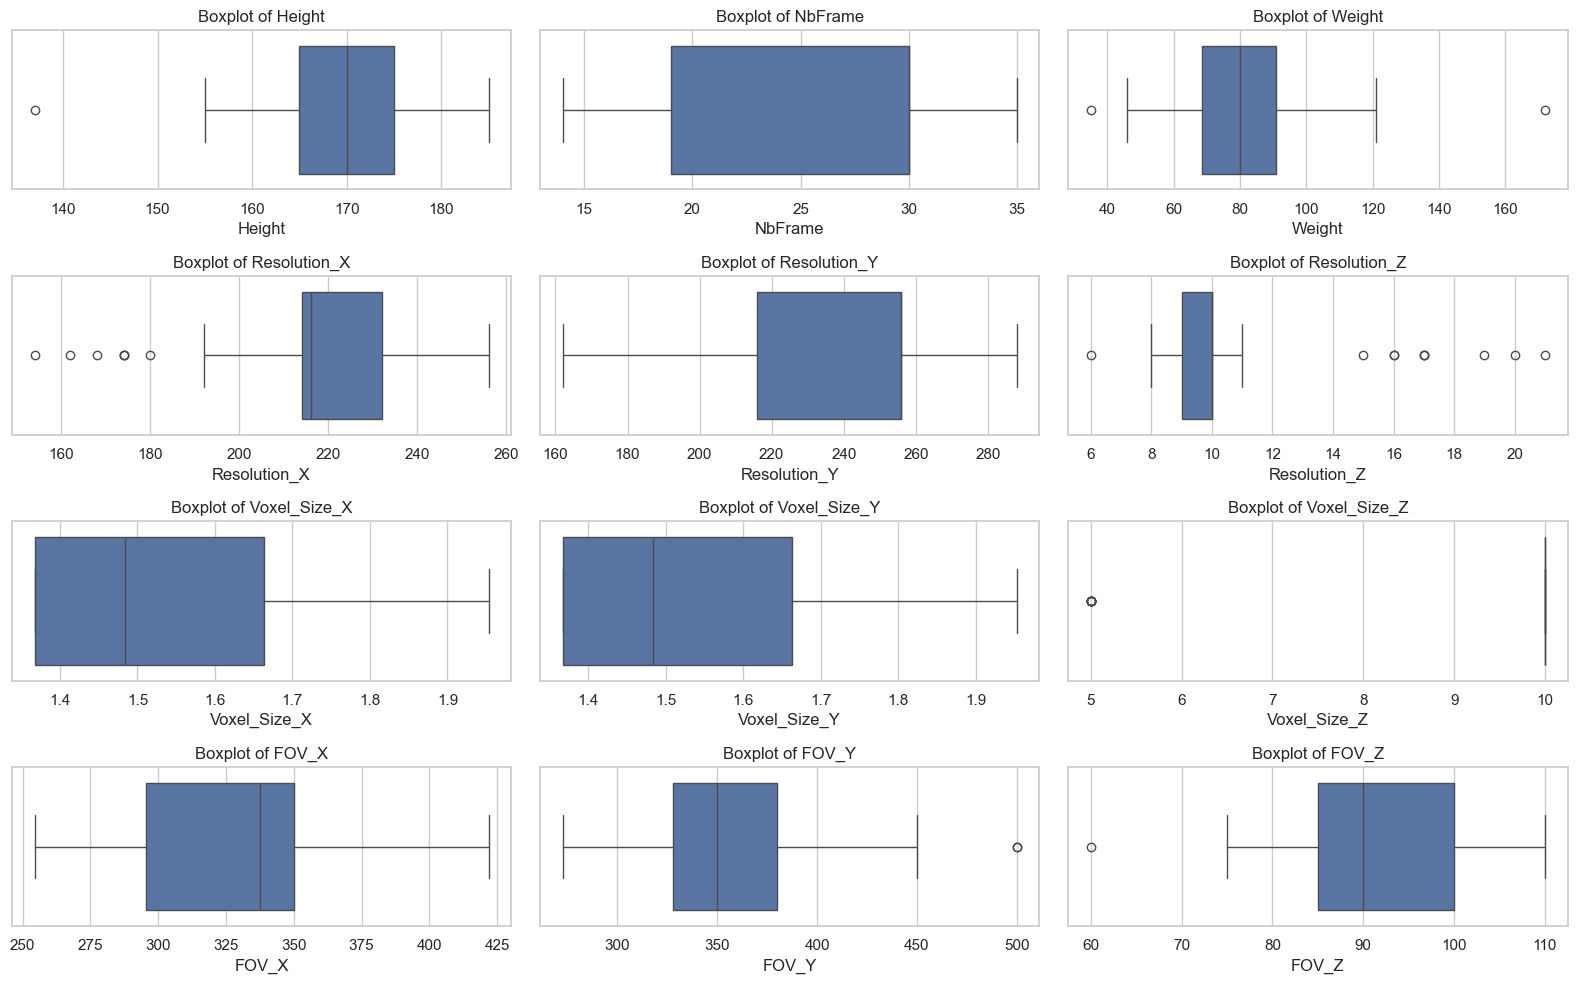

In [69]:
# Set up the figure for boxplots
plt.figure(figsize=(16, 10))

# Loop through the numeric columns and create boxplots
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(data=df_testing_patients, x=col)
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()